In [ ]:
import os
import pickle
import datetime
import contextily
import geoplot
import pygeoda
import scipy
import geopandas as gpd
import pandas as pd
import numpy as np

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import lines
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from pysal.explore import esda
from pysal.lib import weights
from shapely import Polygon
from shapely import Point

In [ ]:
data = pd.read_pickle(f"/content/drive/MyDrive/grids_predictions.pkl")

In [ ]:
## Daily Mean SO2 - Mean
data["mean_so2"].mean()

0.21984477265317387

In [ ]:
## Daily Mean SO2 - Median
data["mean_so2"].median()

0.18752619118336078

In [ ]:
## Daily Mean SO2 - 90-th Percentile
np.percentile(data["mean_so2"], 90)

0.42185342285085514

In [ ]:
## Daily Mean SO2 - Standard Deviation
data["mean_so2"].std()

0.19409253116759967

In [ ]:
## Daily Mean SO2 - Skewness
scipy.stats.skew(data["mean_so2"])

7.517027110642814

In [ ]:
## Daily Max SO2 - Mean
data["max_so2"].mean()

0.7863523225435121

In [ ]:
## Daily Max SO2 - Median
data["max_so2"].median()

0.5910118964902538

In [ ]:
## Daily Max SO2 - 90-th Percentile
np.percentile(data["max_so2"], 90)

1.6568039368370369

In [ ]:
## Daily Max SO2 - Standard Deviation
data["max_so2"].std()

0.7707106567523906

In [ ]:
## Daily Max SO2 - Skewness
scipy.stats.skew(data["max_so2"])

4.28009778672569

In [ ]:
#  exceedance days with respect to WHO Guideline - 24 hour standard (active before 2021)
print(
  (len(sorted(data[(data['mean_so2']>7.5) & (data['year'] == 2022)]['time'].drop_duplicates())),
   len(sorted(data[(data['mean_so2']>7.5) & (data['year'] == 2023)]['time'].drop_duplicates()))
  )
)

(12, 29)


In [ ]:
#  exceedance days with respect to WHO Guideline - 24 hour standard (active since 2021)
print(
  (len(sorted(data[(data['mean_so2']>15) & (data['year'] == 2022)]['time'].drop_duplicates())),
   len(sorted(data[(data['mean_so2']>15) & (data['year'] == 2023)]['time'].drop_duplicates()))
  )
)

(0, 0)


In [ ]:
#  exceedance days with respect to NB Air Quality Objective - 1 hour standard
print(
  (len(sorted(data[(data['max_so2']>56.5) & (data['year'] == 2022)]['time'].drop_duplicates())),
   len(sorted(data[(data['max_so2']>56.5) & (data['year'] == 2023)]['time'].drop_duplicates()))
  )
)

(0, 0)


In [ ]:
data['year'] = data['time'].apply(lambda x: x.year)

annual_data = data.groupby(['id','geometry','year']).agg({"mean_so2_transform": np.mean, "max_so2_transform": np.mean}).reset_index()

annual_data_2022 = annual_data[annual_data['year'] == 2022]
annual_data_2023 = annual_data[annual_data['year'] == 2023]
annual_data_2022 = annual_data_2022.drop(['year'], axis=1)
annual_data_2023 = annual_data_2023.drop(['year'], axis=1)

In [ ]:
# Rook weights
w2022 = weights.Rook.from_dataframe(annual_data_2022)
w2023 = weights.Rook.from_dataframe(annual_data_2023)

In [ ]:
# Gi* statistic
gi_star_2022_mean = esda.getisord.G_Local(annual_data_2022["mean_so2"], w2022, star=True, transform='R', permutations=1000, seed=123)
gi_star_2023_mean = esda.getisord.G_Local(annual_data_2023["mean_so2"], w2023, star=True, transform='R', permutations=1000, seed=123)
gi_star_2022_max = esda.getisord.G_Local(annual_data_2022["max_so2"], w2022, star=True, transform='R', permutations=1000, seed=123)
gi_star_2023_max = esda.getisord.G_Local(annual_data_2023["max_so2"], w2023, star=True, transform='R', permutations=1000, seed=123)

In [ ]:
os.chdir(f"/content/drive/MyDrive/Shapefiles")
csd_shp = gpd.read_file(f"./Subdivision/lcsd000b21a_e.shp")

def polys_critic(i):
    if i.type == "MultiPolygon":
        return [Polygon(x.exterior.coords) for x in i.geoms]
    else:
        return [Polygon(i.exterior.coords)]

csd_sj = csd_shp[csd_shp["CSDNAME"] == "Saint John"]
csd_sj_geom = csd_sj["geometry"].apply(lambda i: polys_critic(i)).explode()
csd_sj_geom_gjs = gpd.GeoDataFrame(csd_sj_geom)
csd_sj_geom_gjs = csd_sj_geom_gjs.set_crs(epsg=3347)
csd_sj_geom_gjs = csd_sj_geom_gjs.to_crs(epsg=4326)

####  **Daily Mean SO2 :**

#####  **2022 :**

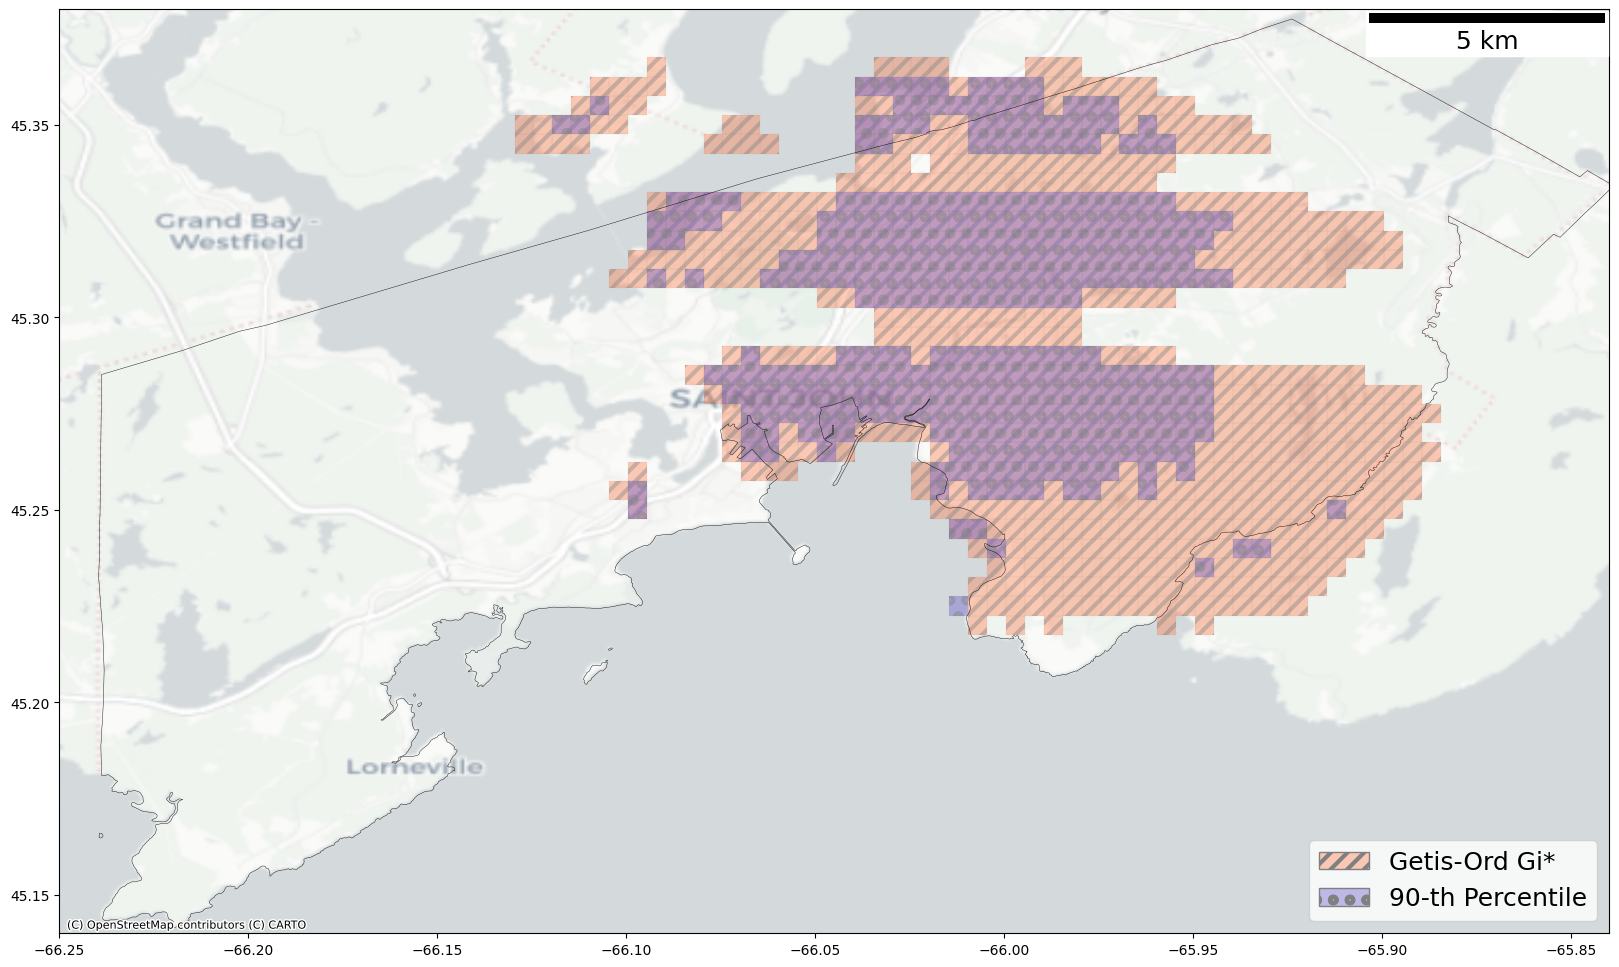

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plt.rcParams['hatch.linewidth'] = 3

ec = "0.5"

db = gpd.GeoDataFrame(annual_data_2022.reset_index(drop=True), crs="epsg:4326")

# Break observations into significant or not
sig = gi_star_2022_mean.p_sim < 0.05
# Plot HH clusters
hh1 = db.loc[(gi_star_2022_mean.Zs > 0) & (sig == True), "geometry"]
hh1.plot(ax=ax, color="coral", edgecolor=ec, linewidth=0.1, alpha=0.4, facecolor="#000000", hatch="//", label = "Getis-Ord Gi*", aspect=None)

# Break observations into significant or not
top_quintile = np.percentile(db["mean_so2"], 90)
low_quintile = np.percentile(db["mean_so2"], 10)
sig = (db["mean_so2"] > top_quintile) | (db["mean_so2"] < low_quintile)

# Plot HH clusters
hh2 = db.loc[(db["mean_so2"] > top_quintile) & (sig == True), "geometry"]
hh2.plot(ax=ax, color="slateblue", edgecolor=ec, linewidth=0.1, alpha=0.4, facecolor="#000000", hatch="o", label = "90-th Percentile", aspect=None)

# add Saint John
gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, facecolor="none", edgecolor='black', linewidth=0.3, aspect=None)

# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.Positron,
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}))

## add legend
lines = [
    Patch(facecolor=t.get_facecolor(), hatch=t.get_hatch(), edgecolor=ec)
    for t in ax.collections[0:-1]
]
labels = [t.get_label() for t in ax.collections[0:-1]]
ax.legend(lines, labels, loc="lower right", prop={'size': 18})

#####  **2023 :**

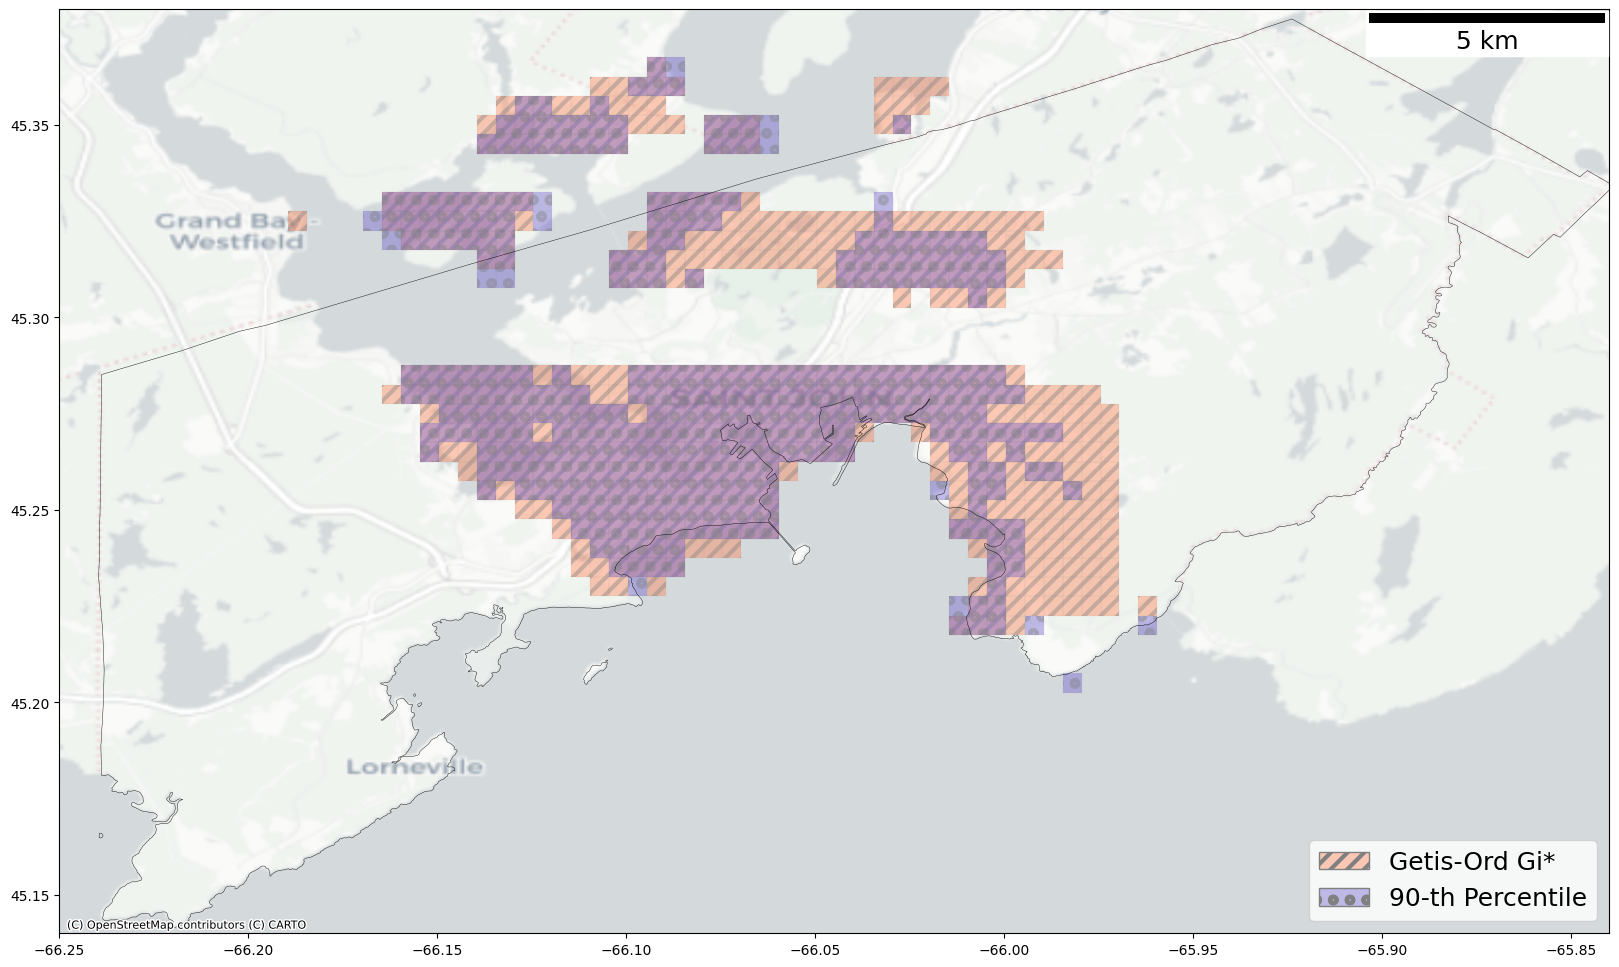

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plt.rcParams['hatch.linewidth'] = 3

ec = "0.5"

db = gpd.GeoDataFrame(annual_data_2023.reset_index(drop=True), crs="epsg:4326")

# Break observations into significant or not
sig = gi_star_2023_mean.p_sim < 0.05
# Plot HH clusters
hh1 = db.loc[(gi_star_2023_mean.Zs > 0) & (sig == True), "geometry"]
hh1.plot(ax=ax, color="coral", edgecolor=ec, linewidth=0.1, alpha=0.4, facecolor="#000000", hatch="//", label = "Getis-Ord Gi*", aspect=None)

# Break observations into significant or not
top_quintile = np.percentile(db["mean_so2"], 90)
low_quintile = np.percentile(db["mean_so2"], 10)
sig = (db["mean_so2"] > top_quintile) | (db["mean_so2"] < low_quintile)

# Plot HH clusters
hh2 = db.loc[(db["mean_so2"] > top_quintile) & (sig == True), "geometry"]
hh2.plot(ax=ax, color="slateblue", edgecolor=ec, linewidth=0.1, alpha=0.4, facecolor="#000000", hatch="o", label = "90-th Percentile", aspect=None)

# add Saint John
gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, facecolor="none", edgecolor='black', linewidth=0.3, aspect=None)

# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.Positron,
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}))

lines = [
    Patch(facecolor=t.get_facecolor(), hatch=t.get_hatch(), edgecolor=ec)
    for t in ax.collections[0:-1]
]
labels = [t.get_label() for t in ax.collections[0:-1]]
ax.legend(lines, labels, loc='lower right', prop={'size': 18})

####  **Daily Max SO2 :**

#####  **2022 :**

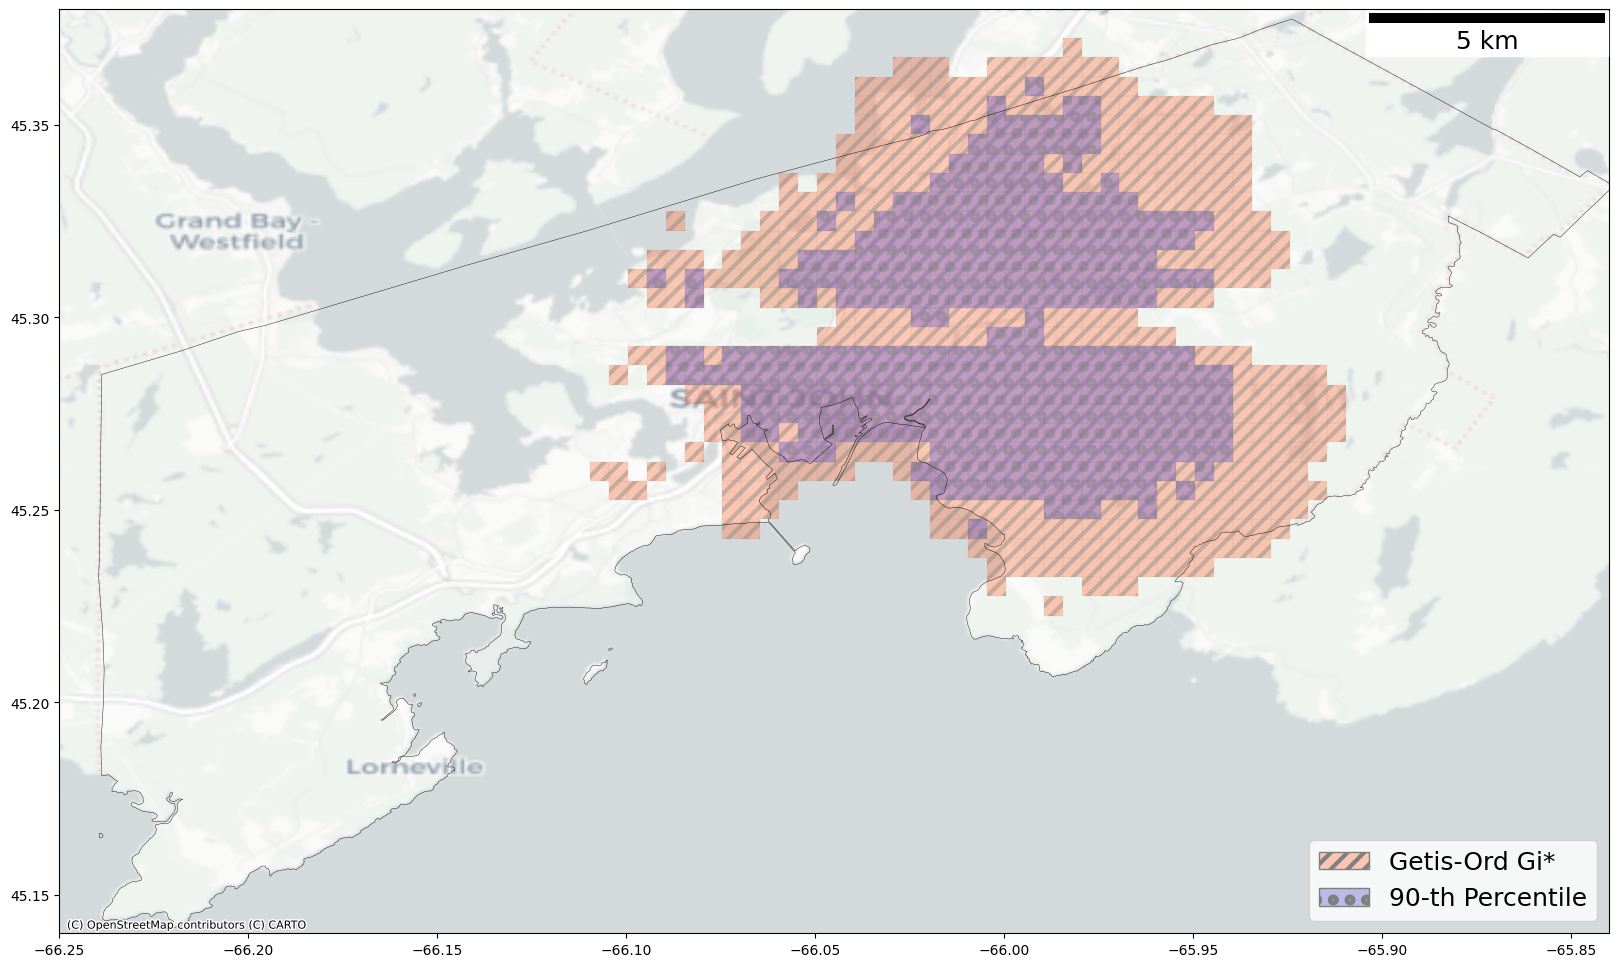

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plt.rcParams['hatch.linewidth'] = 3

ec = "0.5"
db = gpd.GeoDataFrame(annual_data_2022.reset_index(drop=True), crs="epsg:4326")

# Break observations into significant or not
sig = gi_star_2022_max.p_sim < 0.05
# Plot HH clusters
hh1 = db.loc[(gi_star_2022_max.Zs > 0) & (sig == True), "geometry"]
hh1.plot(ax=ax, color="coral", edgecolor=ec, linewidth=0.1, alpha=0.4, facecolor="#000000", hatch="//", label = "Getis-Ord Gi*", aspect=None)

# Break observations into significant or not
top_quintile = np.percentile(db["max_so2"], 90)
low_quintile = np.percentile(db["max_so2"], 10)
sig = (db["max_so2"] > top_quintile) | (db["max_so2"] < low_quintile)

# Plot HH clusters
hh2 = db.loc[(db["max_so2"] > top_quintile) & (sig == True), "geometry"]
hh2.plot(ax=ax, color="slateblue", edgecolor=ec, linewidth=0.1, alpha=0.4, facecolor="#000000", hatch="o", label = "90-th Percentile", aspect=None)

# add Saint John
gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, facecolor="none", edgecolor='black', linewidth=0.3, aspect=None)

# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.Positron,
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}))

## add legend
lines = [
    Patch(facecolor=t.get_facecolor(), hatch=t.get_hatch(), edgecolor=ec)
    for t in ax.collections[0:-1]
]
labels = [t.get_label() for t in ax.collections[0:-1]]
ax.legend(lines, labels, loc="lower right", prop={'size': 18})

#####  **2023 :**

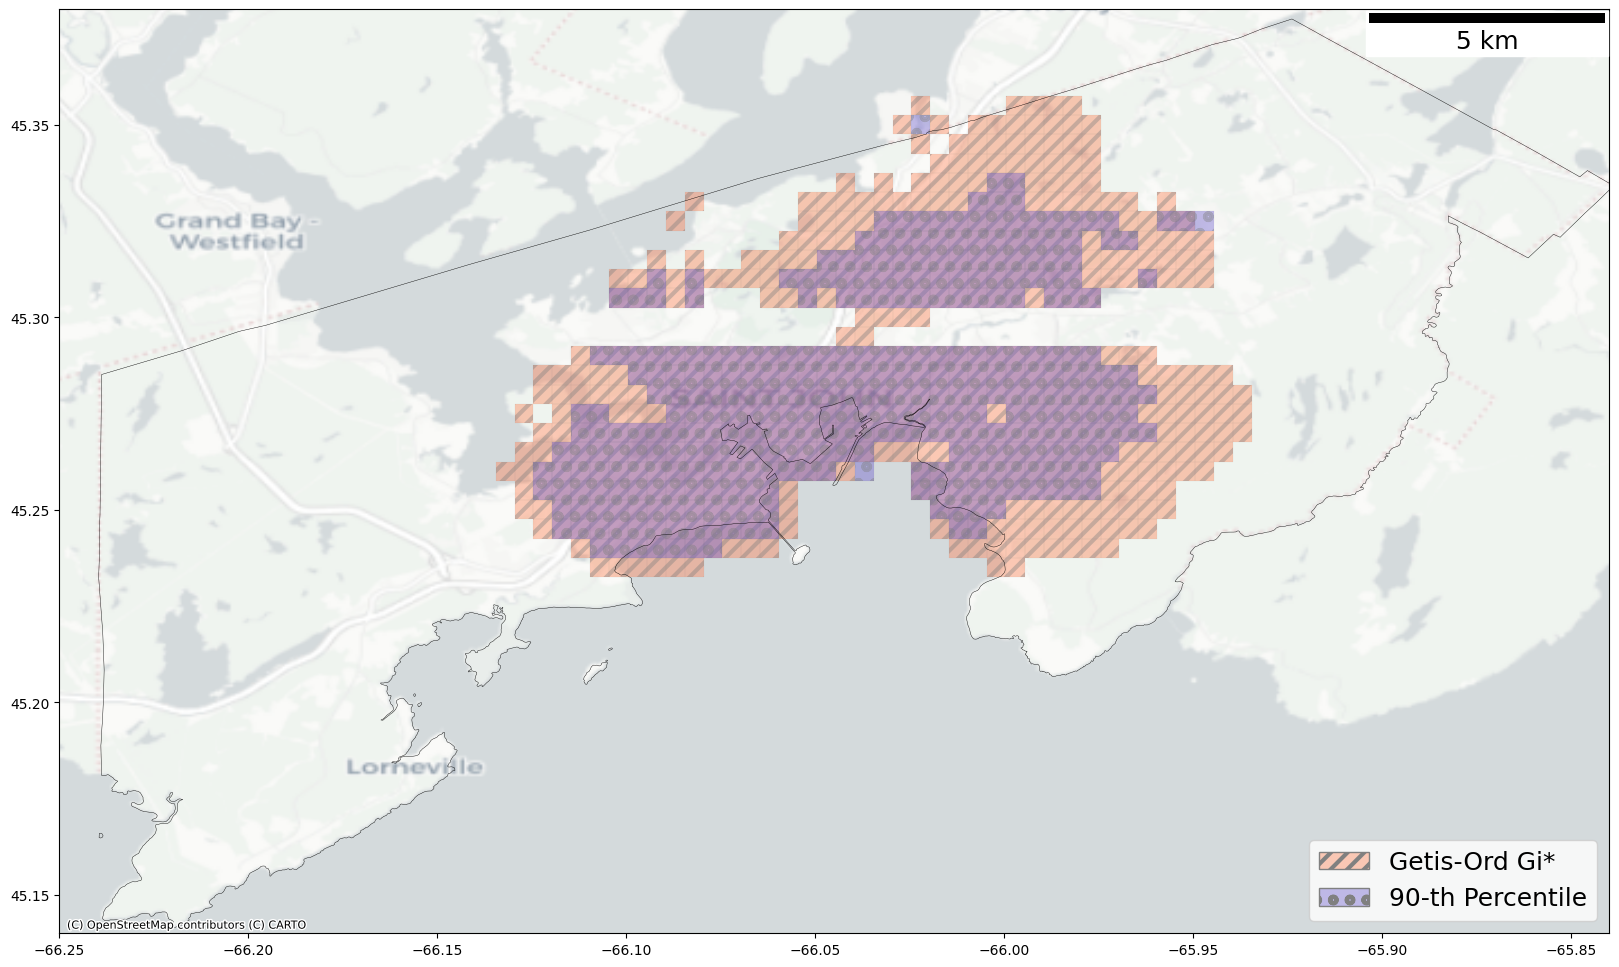

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plt.rcParams['hatch.linewidth'] = 3

ec = "0.5"

db = gpd.GeoDataFrame(annual_data_2023.reset_index(drop=True), crs="epsg:4326")

# Break observations into significant or not
sig = gi_star_2023_max.p_sim < 0.05
# Plot HH clusters
hh1 = db.loc[(gi_star_2023_max.Zs > 0) & (sig == True), "geometry"]
hh1.plot(ax=ax, color="coral", edgecolor=ec, linewidth=0.1, alpha=0.4, facecolor="#000000", hatch="//", label = "Getis-Ord Gi*", aspect=None)

# Break observations into significant or not
top_quintile = np.percentile(db["max_so2"], 90)
low_quintile = np.percentile(db["max_so2"], 10)
sig = (db["max_so2"] > top_quintile) | (db["max_so2"] < low_quintile)

# Plot HH clusters
hh2 = db.loc[(db["max_so2"] > top_quintile) & (sig == True), "geometry"]
hh2.plot(ax=ax, color="slateblue", edgecolor=ec, linewidth=0.1, alpha=0.4, facecolor="#000000", hatch="o", label = "90-th Percentile", aspect=None)

# add Saint John
gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, facecolor="none", edgecolor='black', linewidth=0.3, aspect=None)

# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.Positron,
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}))

## add legend
lines = [
    Patch(facecolor=t.get_facecolor(), hatch=t.get_hatch(), edgecolor=ec)
    for t in ax.collections[0:-1]
]
labels = [t.get_label() for t in ax.collections[0:-1]]
ax.legend(lines, labels, loc="lower right", prop={'size': 18})

####  **TROPOMI SO2 Vertical Column Density :**

In [ ]:
so2_vcd = pd.read_pickle(f"/content/drive/MyDrive/TROPOMI_SO2_15km.pkl")
so2_vcd['year'] = so2_vcd['time'].apply(lambda x: x.year)

In [ ]:
annual_so2_vcd = so2_vcd.groupby(['id','geometry','year']).agg({"SO2_column_number_density_15km_mean": np.mean}).reset_index()

annual_so2_vcd_2022 = annual_so2_vcd[annual_so2_vcd['year'] == 2022]
annual_so2_vcd_2023 = annual_so2_vcd[annual_so2_vcd['year'] == 2023]
annual_so2_vcd_2022 = annual_so2_vcd_2022.drop(['year'], axis=1)
annual_so2_vcd_2023 = annual_so2_vcd_2023.drop(['year'], axis=1)

In [ ]:
# Rook weights
w2022 = weights.Rook.from_dataframe(annual_so2_vcd_2022)
w2023 = weights.Rook.from_dataframe(annual_so2_vcd_2023)

In [ ]:
# Gi* statistic
gi_star_2022 = esda.getisord.G_Local(annual_so2_vcd_2022["SO2_column_number_density_15km_mean"], w2022, star=True, transform='R', permutations=1000, seed=123)
gi_star_2023 = esda.getisord.G_Local(annual_so2_vcd_2023["SO2_column_number_density_15km_mean"], w2023, star=True, transform='R', permutations=1000, seed=123)

#####  **2022 :**

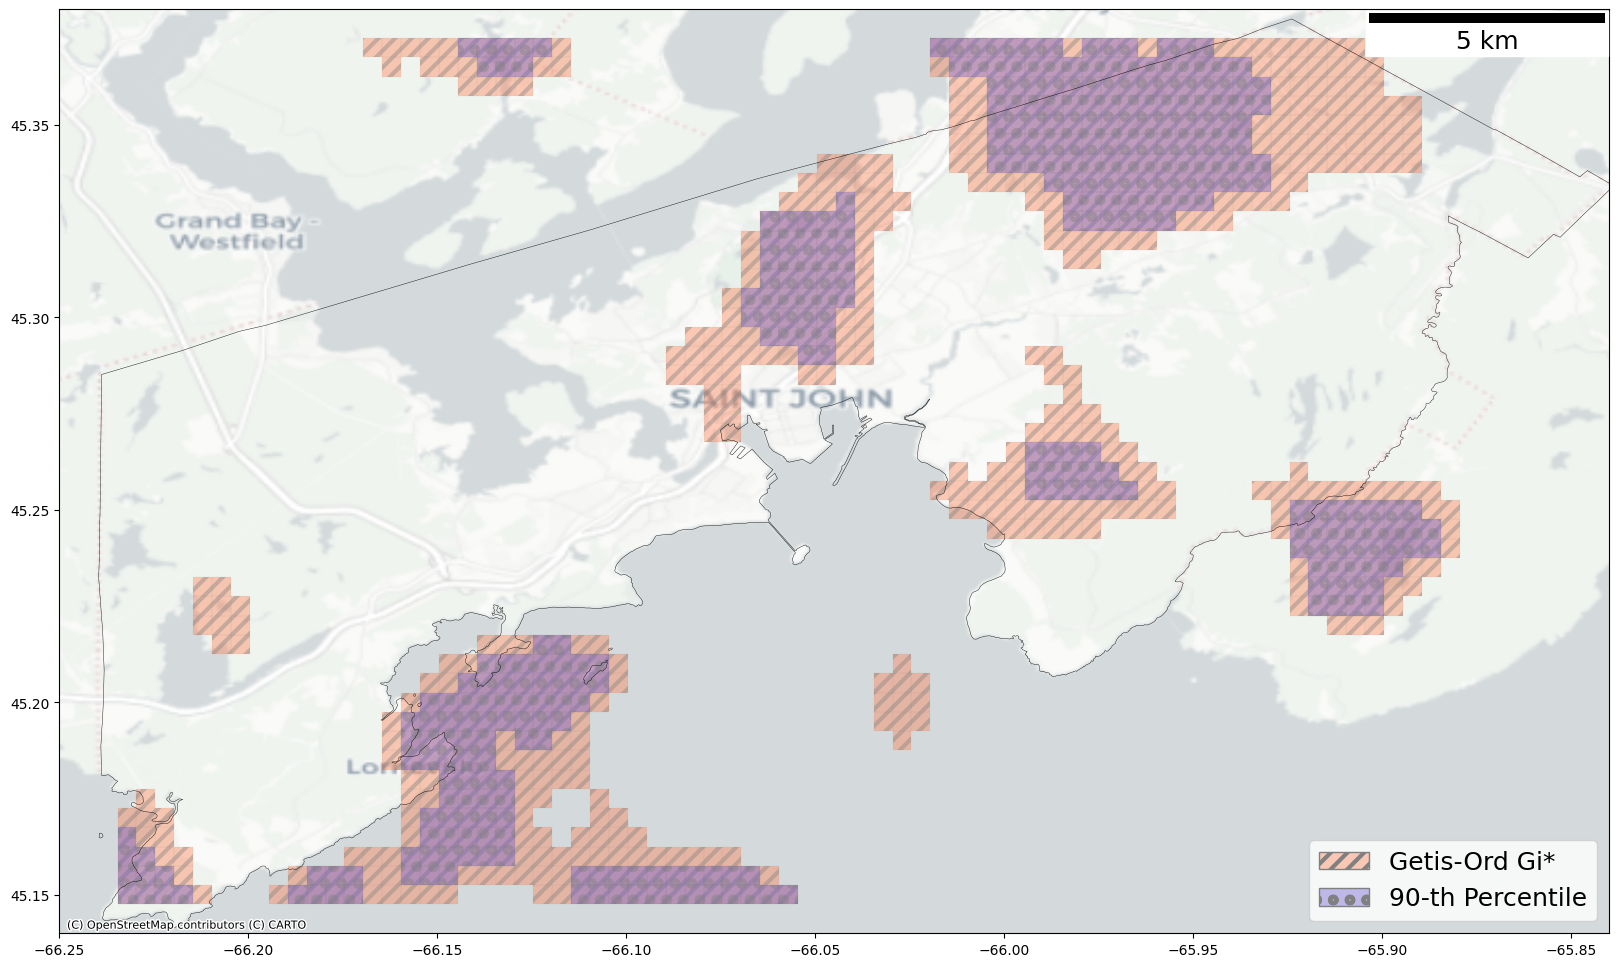

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plt.rcParams['hatch.linewidth'] = 3

ec = "0.5"

db = gpd.GeoDataFrame(annual_so2_vcd_2022.reset_index(drop=True), crs="epsg:4326")

# Break observations into significant or not
sig = gi_star_2022.p_sim < 0.05
# Plot HH clusters
hh1 = db.loc[(gi_star_2022.Zs > 0) & (sig == True), "geometry"]
hh1.plot(ax=ax, color="coral", edgecolor=ec, linewidth=0.1, alpha=0.4, facecolor="#000000", hatch="//", label = "Getis-Ord Gi*", aspect=None)

# Break observations into significant or not
top_quintile = np.percentile(db["SO2_column_number_density_15km_mean"], 90)
low_quintile = np.percentile(db["SO2_column_number_density_15km_mean"], 10)
sig = (db["SO2_column_number_density_15km_mean"] > top_quintile) | (db["SO2_column_number_density_15km_mean"] < low_quintile)

# Plot HH clusters
hh2 = db.loc[(db["SO2_column_number_density_15km_mean"] > top_quintile) & (sig == True), "geometry"]
hh2.plot(ax=ax, color="slateblue", edgecolor=ec, linewidth=0.1, alpha=0.4, facecolor="#000000", hatch="o", label = "90-th Percentile", aspect=None)

# add Saint John
gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, facecolor="none", edgecolor='black', linewidth=0.3, aspect=None)

# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.Positron,
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}))

## add legend
lines = [
    Patch(facecolor=t.get_facecolor(), hatch=t.get_hatch(), edgecolor=ec)
    for t in ax.collections[0:-1]
]
labels = [t.get_label() for t in ax.collections[0:-1]]
ax.legend(lines, labels, loc="lower right", prop={'size': 18})

#####  **2023 :**

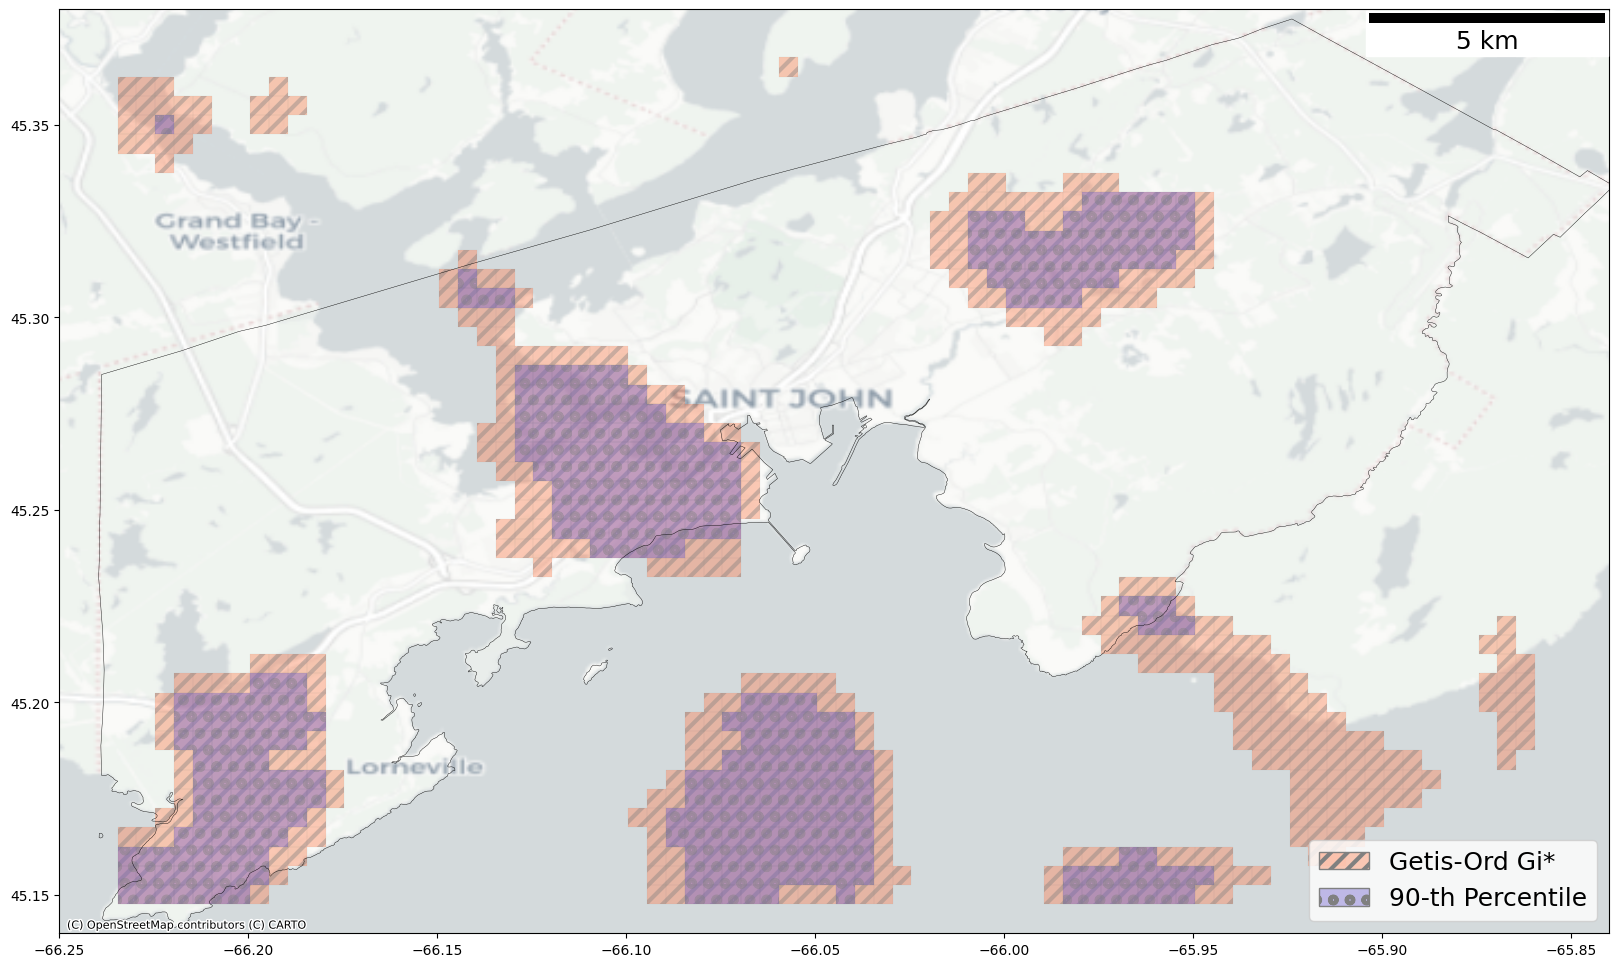

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plt.rcParams['hatch.linewidth'] = 3

ec = "0.5"

db = gpd.GeoDataFrame(annual_so2_vcd_2023.reset_index(drop=True), crs="epsg:4326")

# Break observations into significant or not
sig = gi_star_2023.p_sim < 0.05
# Plot HH clusters
hh1 = db.loc[(gi_star_2023.Zs > 0) & (sig == True), "geometry"]
hh1.plot(ax=ax, color="coral", edgecolor=ec, linewidth=0.1, alpha=0.4, facecolor="#000000", hatch="//", label = "Getis-Ord Gi*", aspect=None)

# Break observations into significant or not
top_quintile = np.percentile(db["SO2_column_number_density_15km_mean"], 90)
low_quintile = np.percentile(db["SO2_column_number_density_15km_mean"], 10)
sig = (db["SO2_column_number_density_15km_mean"] > top_quintile) | (db["SO2_column_number_density_15km_mean"] < low_quintile)

# Plot HH clusters
hh2 = db.loc[(db["SO2_column_number_density_15km_mean"] > top_quintile) & (sig == True), "geometry"]
hh2.plot(ax=ax, color="slateblue", edgecolor=ec, linewidth=0.1, alpha=0.4, facecolor="#000000", hatch="o", label = "90-th Percentile", aspect=None)

# add Saint John
gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, facecolor="none", edgecolor='black', linewidth=0.3, aspect=None)

# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.Positron,
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}))

## add legend
lines = [
    Patch(facecolor=t.get_facecolor(), hatch=t.get_hatch(), edgecolor=ec)
    for t in ax.collections[0:-1]
]
labels = [t.get_label() for t in ax.collections[0:-1]]
ax.legend(lines, labels, loc="lower right", prop={'size': 18})

####  **Sensitivity Analysis :  extracting a week in 2022 with most Exceedances**

In [ ]:
high_data = data[(data['time'] >= datetime.date(2022, 7, 11)) & (data['time'] < datetime.date(2022, 7, 18))] \
              .groupby(['id']) \
              .agg({"mean_so2": [np.mean, top_quintile, mean_exceedance_days],
                    "max_so2": [np.mean, top_quintile, max_exceedance_days]}) \
              .reset_index()

high_data.columns = ["id","mean_so2","mean_so2_top_quin","mean_so2_exceedance","max_so2","max_so2_top_quin","max_so2_exceedance"]
high_data = high_data.merge(data[['id','geometry']].drop_duplicates(), how='left', on=['id'])

In [ ]:
exceedance_stations = pd.concat([nb_so2_records_agg[nb_so2_records_agg['mean_so2'] > 15].sort_values(by=['day_time']),
                                 nb_so2_records_agg[nb_so2_records_agg['max_so2'] > 56.5].sort_values(by=['day_time'])])
exceedance_stations = exceedance_stations[(exceedance_stations['day_time'] >= datetime.date(2022, 7, 11)) &
                                          (exceedance_stations['day_time'] < datetime.date(2022, 7, 18))]
exceedance_stations = nb_stations[nb_stations['station_name'].isin(exceedance_stations['station_name'])]

In [ ]:
# Rook weights
w_high = weights.Rook.from_dataframe(high_data)
# Gi* statistic
gi_star_high_mean = esda.getisord.G_Local(high_data["mean_so2"], w_high , star=True, transform='R', permutations=1000, seed=123)
gi_star_high_max = esda.getisord.G_Local(high_data["max_so2"], w_high , star=True, transform='R', permutations=1000, seed=123)

#####  **Daily Mean SO2 :**

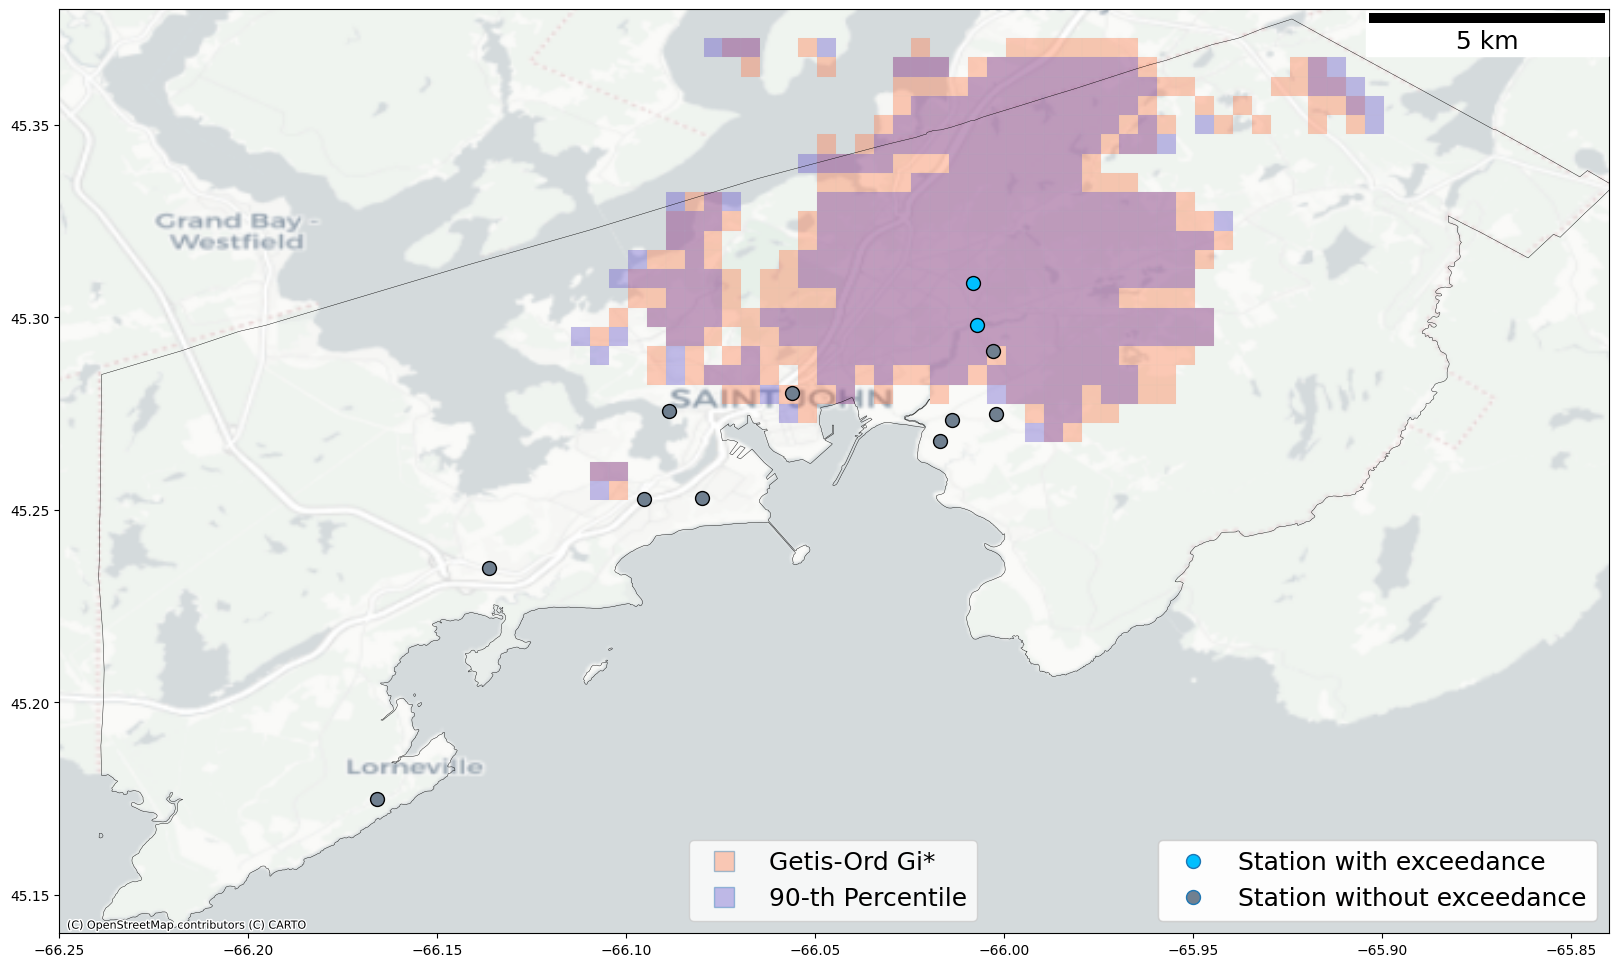

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plt.rcParams['hatch.linewidth'] = 3

ec = "0.8"

db = gpd.GeoDataFrame(high_data, crs="epsg:4326")

# Break observations into significant or not
sig = gi_star_high_mean.p_sim < 0.05

# Plot HH clusters
hh1 = db.loc[(gi_star_high_mean.Zs > 0) & (sig == True), "geometry"]
hh1.plot(ax=ax, color="coral", edgecolor=ec, linewidth=0.1, alpha=0.4, label = "Getis-Ord Gi*", aspect=None)

# Break observations into significant or not
top_quintile = np.percentile(db["mean_so2"], 90)
low_quintile = np.percentile(db["mean_so2"], 10)
sig = (db["mean_so2"] > top_quintile) | (db["mean_so2"] < low_quintile)

# Plot HH clusters
hh2 = db.loc[(db["mean_so2"] > top_quintile) & (sig == True), "geometry"]
hh2.plot(ax=ax, color="slateblue", edgecolor=ec, linewidth=0.1, alpha=0.4, label = "90-th Percentile", aspect=None)

# add station locations with / without exceedance
exceedance_stations.plot(ax=ax, color="deepskyblue", markersize=100, edgecolor='black', linewidth=1, label="Station with exceedance", aspect=None)
nb_stations[~nb_stations['station_name'].isin(exceedance_stations['station_name'])].plot(ax=ax, color="slategrey", markersize=100, edgecolor='black', linewidth=1, label="Station without exceedance", aspect=None)

# add Saint John
gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, facecolor="none", edgecolor='black', linewidth=0.3, aspect=None)

# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.Positron,
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}))

## add legend
lines1 = [
    Line2D([0], [0], linestyle="none", marker="s", markersize=14, markerfacecolor=t.get_facecolor())
    for t in ax.collections[0:-3]
]
labels1 = [t.get_label() for t in ax.collections[0:-3]]
legend1 = ax.legend(lines1, labels1, bbox_to_anchor=(0.6,0), loc="lower right", prop={'size': 18})

lines2 = [
    Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=t.get_facecolor())
    for t in ax.collections[-3:-1]
]
labels2 = [t.get_label() for t in ax.collections[-3:-1]]
legend2 = ax.legend(lines2, labels2, bbox_to_anchor=(1,0), loc="lower right", prop={'size': 18})

ax.add_artist(legend1)
ax.add_artist(legend2)

#####  **Daily Max SO2 :**

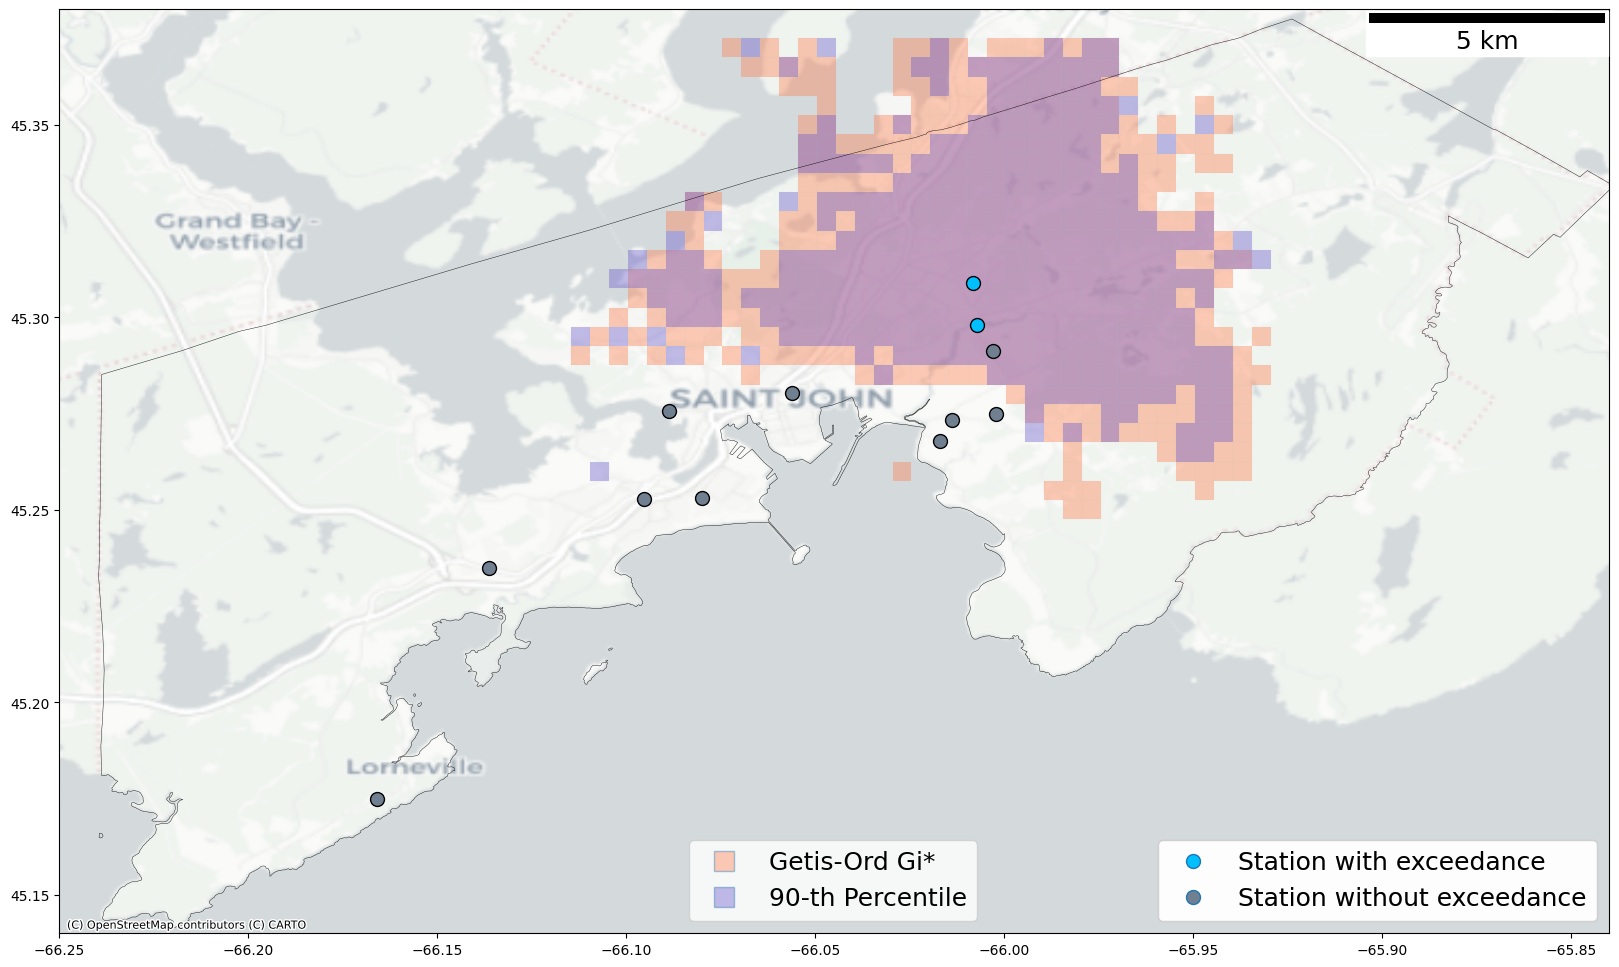

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plt.rcParams['hatch.linewidth'] = 3

ec = "0.8"

db = gpd.GeoDataFrame(high_data, crs="epsg:4326")

# Break observations into significant or not
sig = gi_star_high_max.p_sim < 0.05

# Plot HH clusters
hh1 = db.loc[(gi_star_high_max.Zs > 0) & (sig == True), "geometry"]
hh1.plot(ax=ax, color="coral", edgecolor=ec, linewidth=0.1, alpha=0.4, label = "Getis-Ord Gi*", aspect=None)

# Break observations into significant or not
top_quintile = np.percentile(db["max_so2"], 90)
low_quintile = np.percentile(db["max_so2"], 10)
sig = (db["max_so2"] > top_quintile) | (db["max_so2"] < low_quintile)

# Plot HH clusters
hh2 = db.loc[(db["max_so2"] > top_quintile) & (sig == True), "geometry"]
hh2.plot(ax=ax, color="slateblue", edgecolor=ec, linewidth=0.1, alpha=0.4, label = "90-th Percentile", aspect=None)

# add station locations with / without exceedance
exceedance_stations.plot(ax=ax, color="deepskyblue", markersize=100, edgecolor='black', linewidth=1, label="Station with exceedance", aspect=None)
nb_stations[~nb_stations['station_name'].isin(exceedance_stations['station_name'])].plot(ax=ax, color="slategrey", markersize=100, edgecolor='black', linewidth=1, label="Station without exceedance", aspect=None)

# add Saint John
gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, facecolor="none", edgecolor='black', linewidth=0.3, aspect=None)

# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.Positron,
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}))

## add legend
lines1 = [
    Line2D([0], [0], linestyle="none", marker="s", markersize=14, markerfacecolor=t.get_facecolor())
    for t in ax.collections[0:-3]
]
labels1 = [t.get_label() for t in ax.collections[0:-3]]
legend1 = ax.legend(lines1, labels1, bbox_to_anchor=(0.6,0), loc="lower right", prop={'size': 18})

lines2 = [
    Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=t.get_facecolor())
    for t in ax.collections[-3:-1]
]
labels2 = [t.get_label() for t in ax.collections[-3:-1]]
legend2 = ax.legend(lines2, labels2, bbox_to_anchor=(1,0), loc="lower right", prop={'size': 18})

ax.add_artist(legend1)
ax.add_artist(legend2)